In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [5]:
df = pd.read_csv('Flight_delay.csv')

In [6]:
df.head()

,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,4,03-01-2019,1829,1959,1925,WN,Southwest Airlines Co.,3920,N464WN,90,...,3,10,0,N,0,2,0,0,0,32
1,4,03-01-2019,1937,2037,1940,WN,Southwest Airlines Co.,509,N763SW,240,...,3,7,0,N,0,10,0,0,0,47
2,4,03-01-2019,1644,1845,1725,WN,Southwest Airlines Co.,1333,N334SW,121,...,6,8,0,N,0,8,0,0,0,72
3,4,03-01-2019,1452,1640,1625,WN,Southwest Airlines Co.,675,N286WN,228,...,7,8,0,N,0,3,0,0,0,12
4,4,03-01-2019,1323,1526,1510,WN,Southwest Airlines Co.,4,N674AA,123,...,4,9,0,N,0,0,0,0,0,16


# Select Columns

In [7]:
df = df[['DayOfWeek','Date','DepTime','Airline','Origin','Dest','CarrierDelay']]
df

,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay
0,4,03-01-2019,1829,Southwest Airlines Co.,IND,BWI,2
1,4,03-01-2019,1937,Southwest Airlines Co.,IND,LAS,10
2,4,03-01-2019,1644,Southwest Airlines Co.,IND,MCO,8
3,4,03-01-2019,1452,Southwest Airlines Co.,IND,PHX,3
4,4,03-01-2019,1323,Southwest Airlines Co.,IND,TPA,0
...,...,...,...,...,...,...,...
484546,5,13-06-2019,1609,American Airlines Inc.,DFW,MCO,27
484547,6,14-06-2019,1616,American Airlines Inc.,DFW,MCO,11
484548,2,17-06-2019,1617,American Airlines Inc.,DFW,MCO,0
484549,7,22-06-2019,1607,American Airlines Inc.,DFW,MCO,1


# Check for missing data

In [29]:
df.isnull().sum()

,0
DayOfWeek,0
Date,0
DepTime,0
Airline,0
Origin,0
Dest,0
CarrierDelay,0


# Convert Date Column to Pandas Datetime

In [8]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Create Month And Day Feature

In [9]:
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

### Drop Date now

In [10]:

# Drop the original 'Date' column since XGBoost doesn't handle datetime types
df = df.drop(columns=['Date'])

# Identify Categorical variables

In [11]:
categories = df.select_dtypes(include=['object']).columns
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

# One-Hot Encoding (Dummy Variables) for Categorical Data

In [12]:
df_encoded = pd.get_dummies(df, drop_first=True)

# Prepare Target Variable(s)

In [13]:
df_encoded['is_delayed_60+'] = np.where(df_encoded['CarrierDelay'] > 60, 1, 0)
df_encoded

,DayOfWeek,DepTime,CarrierDelay,month,day,Airline_American Airlines Inc.,Airline_American Eagle Airlines Inc.,Airline_Atlantic Southeast Airlines,Airline_Delta Air Lines Inc.,Airline_Frontier Airlines Inc.,...,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,is_delayed_60+
0,4,1829,2,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,4,1937,10,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,4,1644,8,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,4,1452,3,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,4,1323,0,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484546,5,1609,27,6,13,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
484547,6,1616,11,6,14,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
484548,2,1617,0,6,17,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
484549,7,1607,1,6,22,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


# Define features and target variable


In [14]:
X = df_encoded.drop(columns=['is_delayed_60+', 'CarrierDelay'])
y = df_encoded['is_delayed_60+']

In [16]:
X

,DayOfWeek,DepTime,month,day,Airline_American Airlines Inc.,Airline_American Eagle Airlines Inc.,Airline_Atlantic Southeast Airlines,Airline_Delta Air Lines Inc.,Airline_Frontier Airlines Inc.,Airline_Hawaiian Airlines Inc.,...,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
0,4,1829,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,1937,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,4,1644,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,1452,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,1323,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484546,5,1609,6,13,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
484547,6,1616,6,14,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
484548,2,1617,6,17,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
484549,7,1607,6,22,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Split the data into training and testing sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# LightGBM with Optuna - Handling Imbalanced with SMOTE + LGBM Class Weight


In [ ]:
# LightGBM + Optuna + SMOTE for Imbalanced Classification
import lightgbm as lgb
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

# Apply SMOTE on Training Data Only
print("Before SMOTE:", y_train.value_counts(normalize=True))
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_res.value_counts(normalize=True))

# Objective Function for Optuna
def objective_lgb(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'class_weight': 'balanced',  # still keep balanced weights
        'random_state': 42
    }

    model = lgb.LGBMClassifier(**params)
    auc = cross_val_score(model, X_train_res, y_train_res, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc

# Run Optuna Optimization
study_lgb = optuna.create_study(direction='maximize', study_name='LightGBM_SMOTE')
study_lgb.optimize(objective_lgb, n_trials=30, show_progress_bar=True)

print("\nBest LightGBM Parameters:")
print(study_lgb.best_trial.params)

# Train Final Model with Best Parameters
best_params_lgb = study_lgb.best_trial.params
best_params_lgb['class_weight'] = 'balanced'

lgb_model = lgb.LGBMClassifier(**best_params_lgb)
lgb_model.fit(X_train_res, y_train_res)

# Evaluate Performance
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)

print(f"\nFinal LightGBM ROC-AUC: {auc_lgb:.4f}")

y_pred_lgb = lgb_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))


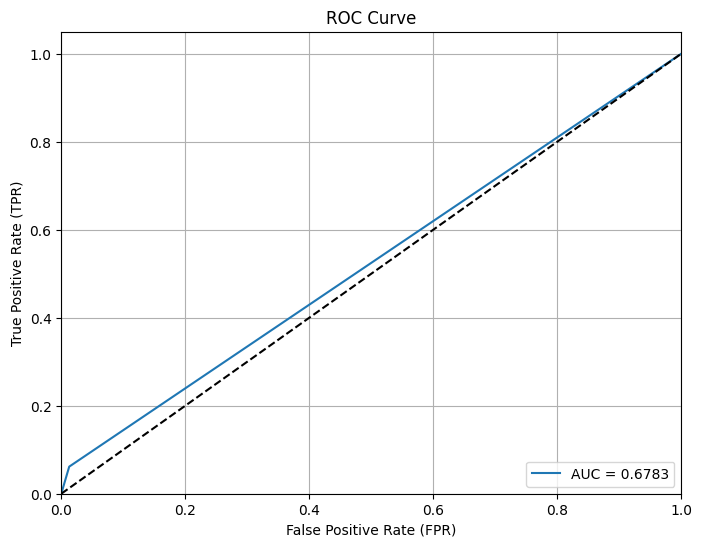

In [40]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_lgb:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# CatBoost with Optuna

In [ ]:
from catboost import CatBoostClassifier, Pool
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE on Training Data Only
print("Before SMOTE:", y_train.value_counts(normalize=True))
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_res.value_counts(normalize=True))

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.1, 2.0),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'verbose': False,
        'random_seed': 42
    }

    model = CatBoostClassifier(**params)

    # 3-fold cross-validation ROC-AUC
    auc = cross_val_score(model, X_train_res, y_train_res, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc

# Create study
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_catboost, n_trials=30, show_progress_bar=True)

print("\nBest CatBoost Parameters:")
print(study_cat.best_trial.params)

# Train final CatBoost model
best_params_cat = study_cat.best_trial.params
cat_model = CatBoostClassifier(**best_params_cat)
cat_model.fit(X_train_res, y_train_res, verbose=False)

# Evaluate
y_pred_cat = cat_model.predict(X_test)
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]
auc_cat = roc_auc_score(y_test, y_pred_proba_cat)

print(f"\n Best CatBoost ROC-AUC on Test Set: {auc_cat:.4f}")


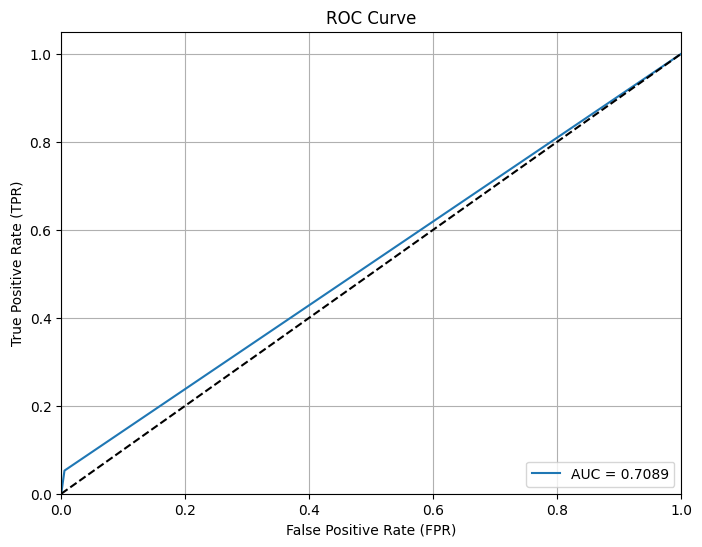

In [18]:
 # Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_cat)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_cat:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()